In [1]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
#from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers


In [2]:
driver_details = pd.read_csv('driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [3]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/Users/vinayasree/Downloads/imgs/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/Users/vinayasree/Downloads/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [4]:

import random
random.shuffle(train_image)
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [5]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [6]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)
np.save('X_train',X_train)
np.save('X_test',X_test)
np.save('y_train',y_train)
np.save('y_test',y_test)

(18732, 224, 224, 3)


#Xception Model

In [7]:
## Defining the input

from keras.layers import Input
xception_input = Input(shape = (224, 224, 3), name = 'Image_input')

from keras.applications.xception import preprocess_input, decode_predictions
from keras.applications.xception import Xception

model_xception_conv = Xception(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_xception_conv.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [8]:
#Use the generated model 
from keras.models import Model


output_xception_conv = model_xception_conv(xception_input)

#Add the fully-connected layers 

x=GlobalAveragePooling2D()(output_xception_conv)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout 
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)


xception_pretrained = Model(inputs = xception_input, outputs = x)
xception_pretrained.summary()


# Compile CNN model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
sgd = optimizers.SGD(lr = 0.005)
xception_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)             

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('xception_weights_aug_extralayer_alltrained_sgd2_V2.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('xception_weights_aug_extralayer_alltrained_sgd2_V2.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
xception_model = xception_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
293/292 [==============================] - ETA: -4s - loss: 2.3438 - accuracy: 0.1453
Epoch 00001: val_loss improved from inf to 2.26873, saving model to xception_weights_aug_extralayer_alltrained_sgd2_V2.hdf5
293/292 [==============================] - 4337s 15s/step - loss: 2.3438 - accuracy: 0.1453 - val_loss: 2.2687 - val_accuracy: 0.2793
Epoch 2/10
293/292 [==============================] - ETA: -4s - loss: 2.0359 - accuracy: 0.2619
Epoch 00002: val_loss improved from 2.26873 to 1.72574, saving model to xception_weights_aug_extralayer_alltrained_sgd2_V2.hdf5
293/292 [==============================] - 4746s 16s/step - loss: 2.0359 - accuracy: 0.2619 - val_loss: 1.7257 - val_accuracy: 0.4456
Epoch 3/10
293/292 [==============================] - ETA: -13s - loss: 1.6085 - accuracy: 0.4242
Epoch 00003: val_loss improved from 1.72574 to 1.14961, saving model to xception_weights_aug_extralayer_alltrain

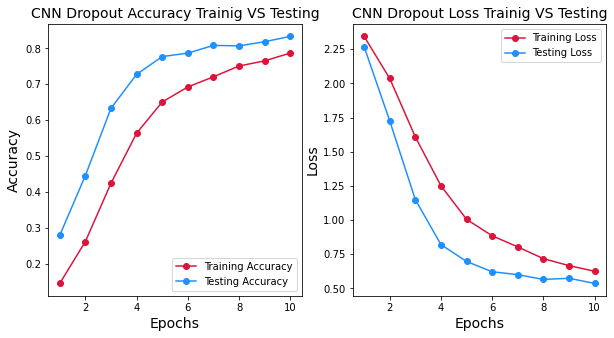

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(xception_pretrained.history.history['accuracy']) + 1), xception_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(xception_pretrained.history.history['val_accuracy']) + 1), xception_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(xception_pretrained.history.history['loss']) + 1), xception_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(xception_pretrained.history.history['val_loss']) + 1), xception_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

#Mobilenet Model

In [12]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
import PIL.Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
#from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras import optimizers


In [13]:
base_model=MobileNet(weights='imagenet',include_top=False) 
# base_model.summary()

In [14]:
x=base_model.output
x=GlobalAveragePooling2D()(x)

preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=preds)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

In [15]:
from keras import optimizers  
sgd = optimizers.SGD(lr = 0.005) 

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy']) 


In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
mobilenet_model = model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 5, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/5
293/292 [==============================] - ETA: -1s - loss: 1.8243 - accuracy: 0.3775
Epoch 00001: val_loss improved from inf to 1.08047, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 1221s 4s/step - loss: 1.8243 - accuracy: 0.3775 - val_loss: 1.0805 - val_accuracy: 0.6487
Epoch 2/5
293/292 [==============================] - ETA: -1s - loss: 1.0267 - accuracy: 0.6693
Epoch 00002: val_loss improved from 1.08047 to 0.60916, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 1213s 4s/step - loss: 1.0267 - accuracy: 0.6693 - val_loss: 0.6092 - val_accuracy: 0.7988
Epoch 3/5
293/292 [==============================] - ETA: -1s - loss: 0.7726 - accuracy: 0.7504
Epoch 00003: val_loss improved from 0.60916 to 0.51395, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 1219s 4s/step - loss: 0.7726 - accuracy: 0.7504 - val_loss: 0.5140 - val_accuracy: 0.8229
Epoch 4/5
293/292

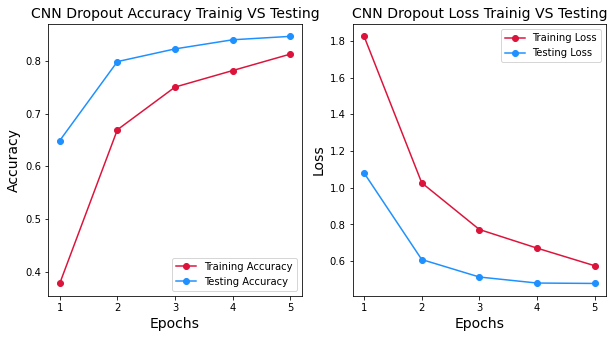

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['accuracy']) + 1), model.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_accuracy']) + 1), model.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

#RESNET50 Model

In [19]:
## Defining the input

from keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50

model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_resnet50_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
#Use the generated model 
from keras.models import Model

from keras.callbacks import LearningRateScheduler
output_resnet50_conv = model_resnet50_conv(resnet50_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_resnet50_conv)
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model(inputs = resnet50_input, outputs = x)
resnet50_pretrained.summary()

# Compile CNN model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)



def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
        math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

sgd = optimizers.SGD(lr = 0.001)


resnet50_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1003530   
Total params: 24,591,242
Trainable params: 24,538,122
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
import math
checkpointer = ModelCheckpoint('resnet_weights_aug_alltrained_sgd2_setval.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper,lrate],
                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/10
293/292 [==============================] - ETA: -3s - loss: 2.5924 - accuracy: 0.3460
Epoch 00001: val_loss improved from inf to 1.51352, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
293/292 [==============================] - 3386s 12s/step - loss: 2.5924 - accuracy: 0.3460 - val_loss: 1.5135 - val_accuracy: 0.6479
Epoch 2/10
293/292 [==============================] - ETA: -3s - loss: 1.3887 - accuracy: 0.6030
Epoch 00002: val_loss improved from 1.51352 to 1.05340, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
293/292 [==============================] - 3307s 11s/step - loss: 1.3887 - accuracy: 0.6030 - val_loss: 1.0534 - val_accuracy: 0.7305
Epoch 3/10
293/292 [==============================] - ETA: -3s - loss: 1.0302 - accuracy: 0.6935
Epoch 00003: val_loss improved from 1.05340 to 0.81754, saving model to resnet_weights_aug_alltrained_sgd2_setval.hdf5
293/292 [==============================] - 3379s 12s/step - loss: 1.0302 - accuracy: 0.6

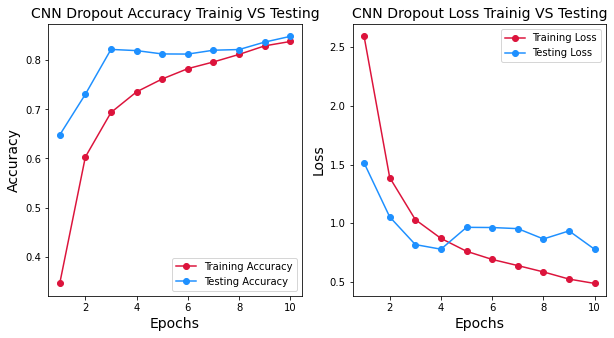

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['loss']) + 1), resnet50_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['val_loss']) + 1), resnet50_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

In [23]:
resnet50_pretrained.history.history['accuracy'][:5]

[0.345985472202301,
 0.6030322313308716,
 0.693519115447998,
 0.7355327606201172,
 0.7616912126541138]

#VGG Model

In [24]:
## Defining the input

from keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
#Use the generated model 
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

x = Flatten(name='flatten')(output_vgg16_conv)

x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(inputs = vgg16_input, outputs = x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/10
293/292 [==============================] - ETA: -5s - loss: 2.3742 - accuracy: 0.1088
Epoch 00001: val_loss improved from inf to 2.27588, saving model to vgg_weights_aug_setval_sgd.hdf5
293/292 [==============================] - 5264s 18s/step - loss: 2.3742 - accuracy: 0.1088 - val_loss: 2.2759 - val_accuracy: 0.1587
Epoch 2/10
293/292 [==============================] - ETA: -4s - loss: 2.2545 - accuracy: 0.1507
Epoch 00002: val_loss improved from 2.27588 to 2.17650, saving model to vgg_weights_aug_setval_sgd.hdf5
293/292 [==============================] - 4883s 17s/step - loss: 2.2545 - accuracy: 0.1507 - val_loss: 2.1765 - val_accuracy: 0.1918
Epoch 3/10
293/292 [==============================] - ETA: -5s - loss: 2.1727 - accuracy: 0.1847
Epoch 00003: val_loss did not improve from 2.17650
293/292 [==============================] - 4989s 17s/step - loss: 2.1727 - accuracy: 0.1847 - val_loss: 2.1802 - val_accuracy: 0.1999
Epoch 4/10
293/292 [==============================] 

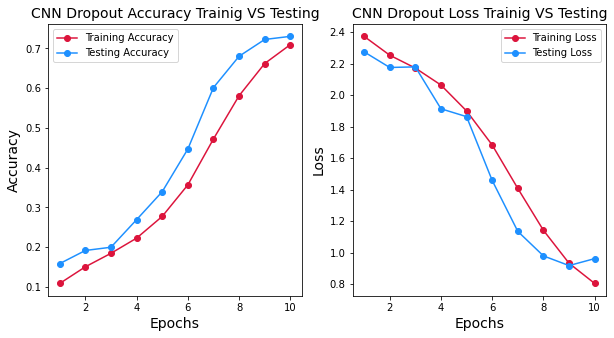

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

